In [1]:
# --- H E R E   B E   I M P O R T S --- #
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import requests
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

#import tensorflow_datasets as tfds
#import tensorflow_text as text
import tensorflow as tf
import tensorflow.data

import nltk
nltk.download('punkt')
from string import digits


#!pip install Keras
#!pip install tensorflow
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

#_____________________________________________________________________________________
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import math
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pylab
from collections import Counter
import csv

# Seq2Seq Items
#import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.python.ops.rnn_cell import LSTMCell
from tensorflow.python.ops.rnn_cell import MultiRNNCell

#from tensorflow.contrib.seq2seq.python.ops import attention_wrapper
from tensorflow.python.layers.core import Dense

import tensorflow

import numpy
from numpy import array
from numpy import asarray
from numpy import zeros

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.utils import to_categorical

import requests
import urllib.request
#from urllib.request import urlopen
from bs4 import BeautifulSoup
import scipy
import matplotlib
import pandas
import statsmodels
import sklearn
#import theano

import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
import fileinput

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arcano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], enable=True)

Num GPUs Available:  1


In [3]:
#Setup for tokenization
max_length = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(
num_words = None,
filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
lower=True,
split=' ',
char_level=False, #if True, every character is tokenized instead of word,
oov_token='eNiV')

In [35]:
print(len(tokenizer.word_index)+1)

17175


Data scraping 

In [4]:
# get rid of line breaks -- used by scraper
def killbreaks(string):
    string = string.replace('\n', ' ')
    string = string.replace('\r', ' ')
    return string

In [5]:
def sparknotesScraper(play):
    '''Writes a processed .txt file for the given shakespearean play on SparkNotes.
    
        Argument: play name as spelled on SparkNotes
            ex: 'Romeo and Juliet' is romeojuliet
        
        Return: None
        
        Output: Two text files, play.txt and playCleaned.txt'''
    
    # i is the current page, sparknotes counts them in even numbers
    i=2
    
    print("Reading {0} from https://www.sparknotes.com/nofear/shakespeare/{0}/ ...".format(play))
    
    # makes a text file to which to copy <div> contents
    with open('{0}.txt'.format(play),"w+",encoding="utf-8")  as fp:
        
        # limit set at 500 pages, just to prevent infinite loop
        #    in case break statement not triggered
        while i <= 1000 :
        
            # 200 is the successful access status code. 300 are redirects
            # and above is garbage, non-200 code means the page doesn't
            # exist or is unreachable
            head = requests.head("https://www.sparknotes.com/nofear/shakespeare/{0}/page_{1}/".format(play,i))
            if head.status_code >= 300:
                print("End of visible play reached, {0} is last visible page at i={1}".format(int(i/2),i))
                break
                
            # start reading html content
            # some <div>s contain linebreaks, killbreaks() gets rid of them
            with urllib.request.urlopen("https://www.sparknotes.com/nofear/shakespeare/{0}/page_{1}/".format(play,i)) as page:
                soup = BeautifulSoup(page)
                table = soup.find("table")
                rows = table.findAll("tr")
                for row in rows:
                    for td in row.find_all("td", {"class":"noFear__cell noFear__cell--original"}):
                        for div in td.find_all("div"):
                            fp.write(killbreaks(div.text)+" ")
                        fp.write("\n")
                    for td in row.find_all("td", {"class":"noFear__cell noFear__cell--modern"}):
                        for div in td.find_all("div"):
                            fp.write(killbreaks(div.text)+" ")
                        fp.write("\n\n")
            
            if i%50 == 0:
                print("Reached page {0} at i={1},".format(int(i/2),i))
            
            i+=2
            
        print('\'{0}\' is read.'.format(play))

In [ ]:
# to add : henry4pt1 and henry4pt2 (odd indices)
filenames = ['hamlet.txt', 'romeojuliet.txt', 'lear.txt', 'juliuscaesar.txt', 'henryv.txt', 'coriolanus.txt', 'errors.txt', 'asyoulikeit.txt','antony-and-cleopatra.txt', 'measure-for-measure.txt', 'merchant.txt', 'msnd.txt', 'othello.txt', 'richardii.txt', 'richardiii.txt', 'shrew.txt', 'tempest.txt', 'twelfthnight.txt', 'twogentlemen.txt', 'winterstale.txt']
with open('trainingSet.txt', 'w', encoding="utf-8") as outfile:
    for fname in filenames:
        with open(fname, encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)

Dataset pairing and cleaning

In [7]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def load_document(filename):
    #open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    #store in variable  
    text=file.read()
    #close it
    file.close
    return text

def make_pairs(document):
    #group the corresponding lines
    to_be_paired = document.split('\n\n')
    #pair the corresponding translations
    line_pairs = [line.split('\n') for line in to_be_paired]
    return line_pairs

#---dataset cleaning------
##Note that this is partially done by the tokenizer already
##however, we implemented our own version Before using that
##tokenizer, so we keep both for compatibility just in case
def clean(pairs, num_sentences):
    if num_sentences == 'all':
        num_sentences = len(pairs)-1
    cleaned= []
    # regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    for pair in pairs[:num_sentences]:
        clean_pair = [] 
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [re_print.sub('', word) for word in line]
            # remove tokens with numbers in them
            line = [word.translate(str.maketrans('', '', digits)) for word in line]
            # add space before punctuation
            line = [re.sub('([.,!?()])', r' \1 ', word) for word in line]
            # remove extra spaces
            line = [re.sub(' +', ' ', word) for word in line]
            # store as string
            clean_pair.append(' '.join(line))
        # keep only pairs of 2
        if len(clean_pair) == 2:
            # split into sentences instead of lines
            if len(nltk.tokenize.sent_tokenize(clean_pair[0])) > 1 :
                first = nltk.tokenize.sent_tokenize(clean_pair[0])
                second = nltk.tokenize.sent_tokenize(clean_pair[1])
                # add a start and an end token to the sentences
                first = ['<start> ' + sentence + ' <end>' for sentence in first]
                second = ['<start> ' + sentence + ' <end>' for sentence in second]
                length = min(len(first), len(second))
                i=0
                while i < length :
                # keep only short sentences and verify the lengths are about the same
                    if len(first[i]) < max_length +15 and (2.5*len(first[i]) > len(second[i]) or 2.5*len(first[i]) > len(second[i])):
                         cleaned.append([first[i],second[i]])
                    i+=1
            else :
                # keep only short sentences
                if len(clean_pair[0]) < max_length :
                    # add a start and an end token to the sentences
                    clean_pair = ['<start> ' + sentence + ' <end>' for sentence in clean_pair]
                    cleaned.append(clean_pair)
    #print(cleaned)
    return zip(*cleaned)

def load_dataset(path, num_sentences):
    # load dataset
    doc = load_document(path)
    # split into pairs
    pairs = make_pairs(doc)
    #clean sentences
    cleaned_pairs = clean(pairs, num_sentences)
    # save clean pairs to file  
    #save_clean_data(cleaned_pairs, 'translation-clean.pkl')
    # associate sentences to their respective language 
    shakespeare, modern = cleaned_pairs
    print(modern[1])
    # make a vocabulary and fit the tokenizer on it
    vocabularySource = shakespeare + modern
    tokenizer.fit_on_texts(vocabularySource)
    #print(modern[1])
    # vectorize
    modern_vector = pad(tokenize(modern))
    print(modern_vector[1])
    shakespeare_vector = pad(tokenize(shakespeare))
    
    return modern_vector, shakespeare_vector, vocabularySource

def pad(language_vector):
    for sentence in language_vector:
        # add 0s to sentence vector until it is
        # the same length as max_length
        for i in range(len(sentence), max_length):
            sentence.append(0) 
    return language_vector

def tokenize(array):
    token = tokenizer.texts_to_sequences(array)
    return token

In [8]:
modern_vector, shakespeare_vector, vocabularySource = load_dataset('trainingSet.txt', 'all')

<start> whos there ?  <end>
[2, 317, 74, 11, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


-------------------------------------------
The vast majority of what follows is unoriginal -- we were authorized to make use of pre-built libraries such as scikit-learn, but to our knowledge, there exists no ready-made transformer translator, and we were (rather unsurprisingly) unable to create our own.

The principal source is thus: https://www.tensorflow.org/tutorials/text/transformer

The modifications, where they occur, are mostly for dataset compatibility -- ours and the tutorials' were different and we did not have the same capabilities or built-in functions such as tokenizers.

Positional Encoding

(1, 2048, 512)


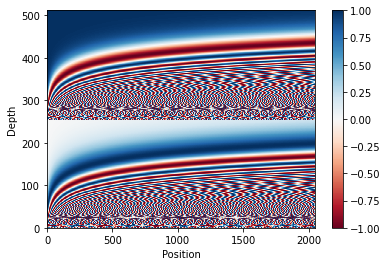

In [9]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Padding Mask

In [10]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, -1), tf.float32)
    # add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

Attention

In [11]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

      Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

      Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

Encoder and Decoder Layers

In [13]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [15]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

Encoder and Decoder

In [16]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [17]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

Transformer model

In [18]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,  input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [19]:
#Settings/parameters and model initialization
#While mostly arbitrary, these hyperparameters
#were inspired by the Attention is All You Need
#paper
num_layers = 6
d_model = 128
dff = 1024
num_heads = 16
dropout_rate = 0.2

transformer = Transformer( num_layers=num_layers,
                           d_model=d_model,
                           num_heads=num_heads,
                           dff=dff,
                           input_vocab_size=len(tokenizer.word_index)+1,
                           target_vocab_size=len(tokenizer.word_index)+1, 
                           pe_input=1000, 
                           pe_target=1000,
                           rate=dropout_rate)

Schedule

In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Loss and accuracy functions 

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [22]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [23]:
tensormodEngENC = tf.convert_to_tensor(modern_vector, dtype=tf.int64)
tensorshakeEngENC = tf.convert_to_tensor(shakespeare_vector, dtype=tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((tensormodEngENC,tensorshakeEngENC))

#This function is technically useless, but included for
#compatibility -- the tutorial source we used does more
#with it, but it is not needed in our implementation.
#Unfortunately, it is called in a complicated (for us) way.
def tokenize_pairs(sha, mod):
    return sha, mod

In [24]:
#Partition dataset into batches for training
BUFFER_SIZE = 20000
BATCH_SIZE = 100
def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE))

dset = make_batches(dataset)

In [25]:
#Weights are saved as checkpoints
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [26]:
#Setup for training
EPOCHS = 600   # <<<================||X+

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                         True, 
                                         enc_padding_mask, 
                                         combined_mask, 
                                         dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
# --- T R A I N I N G --- #
# GPUs BEWARE

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> english, tar -> shakespearean
    for (batch, (inp, tar)) in enumerate(dset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [27]:
#The transformer functions by building an output 
#word-by-word, starting from the <start> token
#that signifies the beginning of a sentence.
#There is a significant number of unused content
#in this method. We were not able to implement
#these before the D3 submission deadline.
def evaluate(sentence):
    sentence = tokenizer.texts_to_sequences([sentence])
    difference = max_length - len(sentence[0])
    while difference > 0:
        sentence[0].append(0)
        difference = difference - 1
    encoder_input = tf.convert_to_tensor(sentence)
    encoder_input = tf.cast(encoder_input, tf.int32)
    start = 2
    end = 3
    output = [2]
    output = tf.convert_to_tensor([output])
    output = tf.cast(output, tf.int32)
    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        predictions = predictions[: ,-1:, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        predicted_id = tf.cast(predicted_id, tf.int32)
        output = tf.cast(output, tf.int32)
        output = tf.concat([output, predicted_id], axis=-1)
        if predicted_id == end:
            break
    arrayn = output.numpy()
    text = tokenizer.sequences_to_texts(arrayn)

    return text

Sample outputs:

In [36]:
sentence = "<start> i jbdfghfgdhdfghdfgh <end>"
print(evaluate(sentence))

['<start> i , isnt didnt <end>']


In [37]:
sentence = "<start> juliet <end>"
print(evaluate(sentence))

['<start> dared <end>']


In [38]:
sentence = "<start> i swear to god , i am exceedingly tired . <end>"
print(evaluate(sentence))

['<start> to not sword go now to completely , terms husband and <end>']
